In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

from src.settings import Config
from src.utils import Network, Results #,DataProcessor
from src.models import SpatialAggregation, TemporalAggregation
from src.visualization import Visualizer
from Full_GTEP_Solve.modules_v2 import read_data, GTEP

import pickle
import xarray as xr
import numpy as np
from numba import njit, prange
import pandas as pd
import matplotlib.pyplot as plt
import time
import gurobipy as gp
from gurobipy import GRB

In [18]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from typing import Any
from functools import lru_cache
from dataclasses import asdict
import hashlib
import json
from numba import njit, prange
from datetime import datetime

from sklearn.neighbors import NearestNeighbors

In [19]:
config = Config(
    year=2013,
    cf_k_neighbors=1,
    demand_decay_alpha=0.4,
    granularity="high_bis",
    active_features=['position', 'time_series', 'duration_curves', 'ramp_duration_curves', 'intra_correlation']
)

# # Display configuration help.
# config.help()

In [20]:
def process_capacity_factors(wind, solar) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Process capacity factors for wind and solar"""
        wind_points = np.column_stack((wind.lat.values, wind.lon.values))
        wind_values = wind.values.astype(np.float64)
        solar_points = np.column_stack((solar.lat.values, solar.lon.values))
        solar_values = solar.values.astype(np.float64)

        wind_values = np.delete(wind_values, 181, axis=1) # Remove the 181st column for wind data
        wind_points = np.delete(wind_points, 181, axis=0)  # Remove the 181st row for wind data

        wind_df = pd.DataFrame(wind_values, columns=range(wind_values.shape[1]))
        solar_df = pd.DataFrame(solar_values, columns=range(solar_values.shape[1]))

        if not np.array_equal(wind_points, solar_points):
            raise ValueError("Wind and solar points do not match!")
        
        nodes_df = pd.DataFrame(wind_points, columns=["Lat", "Lon"])
            
        return nodes_df, wind_df, solar_df

In [21]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


def load_data(config: Config) -> tuple[xr.DataArray, xr.DataArray, pd.DataFrame, pd.DataFrame]:
    """
    Load and preprocess wind, solar, and demand data.

    Returns:
        wind (xr.DataArray): Stacked and cleaned wind capacity factors.
        solar (xr.DataArray): Stacked and cleaned solar capacity factors.
        df_demand (pd.DataFrame): Demand time series (in MW).
        df_demand_lat_lon (pd.DataFrame): Demand location coordinates.
    """
    wind = xr.open_dataset(config.path.wind_cf_file)['cf']
    solar = xr.open_dataset(config.path.solar_cf_file)['cf']
    wind = wind.stack(z=("lat", "lon")).dropna('z', how='all')
    solar = solar.stack(z=("lat", "lon")).dropna('z', how='all')

    demand_df = pd.read_csv(config.path.demand_file).iloc[:, 1:] * 1000  # Convert from GW to MW
    # demand_lat_lon_df = pd.read_csv(config.path.demand_lat_lon_file)[['Lat', 'Lon']]
    # demand_lat_lon_df['Lon'] = -demand_lat_lon_df['Lon']

    population_df = pd.read_csv(config.path.population_file)
    population_df = population_df.rename(columns={"longitude": "Lon", "latitude": "Lat"})

    return wind, solar, demand_df, population_df

def get_counties(config: Config) -> gpd.GeoDataFrame:
    """ 
    Load and filter New England counties from shapefile.
    Returns:
        counties (gpd.GeoDataFrame): Filtered counties with geometry and FIPS codes.
    """
    # 2) Read New England county polygons
    COUNTY_SHP =  config.path.county_file
    counties = gpd.read_file(COUNTY_SHP).to_crs(epsg=4326)
    ne_fips = ["09","23","25","33","44","50"]  # CT, ME, MA, NH, RI, VT
    counties = counties[counties["STATEFP"].isin(ne_fips)]
    counties["county_id"] = counties["GEOID"]  # e.g. "25027"
    return counties


class FineNetwork():
    def __init__(self, config: Config):     
        self.config = config
        self.wind, self.solar, self.demand_df, self.population_df = load_data(config)
        self.counties = get_counties(config)

    def _process_capacity_factors(self) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Process capacity factors for wind and solar"""
        wind = self.wind
        solar = self.solar
        wind_points = np.column_stack((wind.lat.values, wind.lon.values))
        wind_values = wind.values.astype(np.float64)
        solar_points = np.column_stack((solar.lat.values, solar.lon.values))
        solar_values = solar.values.astype(np.float64)

        wind_values = np.delete(wind_values, 181, axis=1) # Remove the 181st column for wind data
        wind_points = np.delete(wind_points, 181, axis=0)  # Remove the 181st row for wind data

        wind_df = pd.DataFrame(wind_values, columns=range(wind_values.shape[1]))
        solar_df = pd.DataFrame(solar_values, columns=range(solar_values.shape[1]))

        if not np.array_equal(wind_points, solar_points):
            raise ValueError("Wind and solar points do not match!")
        
        nodes_df = pd.DataFrame(wind_points, columns=["Lat", "Lon"])
            
        return nodes_df, wind_df, solar_df
    
    def _process_demand(self, nodes_df) -> pd.DataFrame:
        """Process demand data and disaggregate it to grid nodes"""
        demand_df = self.demand_df
        population_df = self.population_df
        counties = self.counties

        # 3) Attach each population hexagon to a county
        pop_gdf = gpd.GeoDataFrame(
            population_df,
            geometry=gpd.points_from_xy(population_df.Lon, population_df.Lat),
            crs="EPSG:4326"
        )
        # spatial join on “within”
        pop_gdf = gpd.sjoin(pop_gdf, counties[["county_id","geometry"]],
                            how="left", predicate="within")

        # for any population point that fell outside (NaN county_id), snap to the nearest county
        missing_pt = pop_gdf["county_id"].isna()
        if missing_pt.any():
            # build centroids and kd‑tree of county centroids
            cents = np.vstack([
                counties.geometry.centroid.y,
                counties.geometry.centroid.x
            ]).T
            nbr = NearestNeighbors(n_neighbors=1).fit(cents)
            pts = np.vstack([pop_gdf.loc[missing_pt,"Lat"], pop_gdf.loc[missing_pt,"Lon"]]).T
            _, idx = nbr.kneighbors(pts)
            pop_gdf.loc[missing_pt,"county_id"] = counties.iloc[idx.flatten()]["county_id"].values

        # 4) Snap each population point to its nearest grid node
        grid_coords = np.vstack([nodes_df.Lat, nodes_df.Lon]).T
        nbr_nodes = NearestNeighbors(n_neighbors=1).fit(grid_coords)
        pop_pts = np.vstack([pop_gdf.Lat, pop_gdf.Lon]).T
        _, node_idx = nbr_nodes.kneighbors(pop_pts)
        pop_gdf["node_id"] = node_idx.flatten()

        # 5) Compute population per (county_id, node_id)
        pop_cn = (
            pop_gdf
            .groupby(["county_id","node_id"])["population"]
            .sum()
            .unstack(fill_value=0)   # rows=county_id, cols=node_id
        )

        # 6) Build weight matrix W where each row sums to 1
        W = pop_cn.div(pop_cn.sum(axis=1), axis=0).fillna(0)
        #    — if a county had zero total pop (unlikely), its row becomes all zeros

        # 7) Reorder demand_df to match W’s rows, then disaggregate
        demand_df.columns = demand_df.columns.map(lambda x: str(x).zfill(5)) # Ensure demand_df columns are zero-padded to 5 digits (FIPS codes)
        demand_df = demand_df.loc[:, W.index]    # ensure same county order
        grid_demand = demand_df.values.dot(W.values)
        grid_demand_df = pd.DataFrame(
            grid_demand,
            index=demand_df.index,
            columns=W.columns
        )

        if not np.allclose(grid_demand_df.sum(axis=1),demand_df.sum(axis=1),atol=1e-6):
            raise ValueError("Demand conservation check failed!")
        
        return grid_demand_df

    def build_fine_ntw(self) -> dict[str, pd.DataFrame | dict[str, pd.DataFrame]]:
        """ 
        Process the data and return a dictionary of DataFrames.
        """
        nodes_df, wind_df, solar_df = self._process_capacity_factors()
        grid_demand_df = self._process_demand(nodes_df)
        return {
            'nodes': nodes_df,
            'time_series':{
                'wind': wind_df,
                'solar': solar_df,
                'demand': grid_demand_df
                }
            }
    

In [22]:
Fine_NTW = FineNetwork(config)
fine_ntw = Fine_NTW.build_fine_ntw()

C:\Users\g630d\AppData\Local\Temp\ipykernel_27268\1280902233.py:96: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.geometry.centroid.y,
C:\Users\g630d\AppData\Local\Temp\ipykernel_27268\1280902233.py:97: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.geometry.centroid.x


In [23]:
from sklearn.metrics import pairwise_distances

class CoarseNetwork():
    def __init__(self, config: Config, fine_network: dict[str, pd.DataFrame | dict[str, pd.DataFrame]]):
        self.config = config
        self.fine_network = fine_network
        
        coarse_nodes_df = pd.read_csv(config.path.coarse_node_file)[['Lat', 'Lon']]
        coarse_nodes_df['Lon'] = -coarse_nodes_df['Lon']
        self.coarse_nodes_df = coarse_nodes_df

        nbr = NearestNeighbors(n_neighbors=1).fit(self.coarse_nodes_df.values)
        _, zones = nbr.kneighbors(self.fine_network['nodes'].values)
        self.fine_to_coarse = zones.flatten() 

    def _aggregate_capacity_factors(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        """Aggregate capacity factors for wind and solar by taking the medoid of each zone."""
        wind = self.fine_network['time_series']['wind']
        solar = self.fine_network['time_series']['solar']

        C = len(self.coarse_nodes_df)
        T = wind.shape[0]

        # placeholders
        wind_coarse  = pd.DataFrame(index=wind.index,  columns=range(C), dtype=float)
        solar_coarse = pd.DataFrame(index=solar.index, columns=range(C), dtype=float)

        for zone in range(C):
            # fine nodes assigned to this zone
            mask = (self.fine_to_coarse == zone)
            idxs = np.where(mask)[0]

            if len(idxs) == 0:
                raise ValueError(f"Zone {zone} has no fine nodes assigned!")

            # slice out the sub‑matrices
            wsub = wind.iloc[:, idxs]
            ssub = solar.iloc[:, idxs]

            # compute pairwise distances and pick medoid
            Dw = pairwise_distances(wsub.T)      # k×k
            medoid_w = idxs[ Dw.sum(axis=0).argmin() ]
            Ds = pairwise_distances(ssub.T)
            medoid_s = idxs[ Ds.sum(axis=0).argmin() ]

            # assign the medoid time series
            wind_coarse.iloc[:, zone]  = wind.iloc[:, medoid_w].values
            solar_coarse.iloc[:, zone] = solar.iloc[:, medoid_s].values

        return wind_coarse, solar_coarse

    def _aggregate_demand(self) -> pd.DataFrame:
        """
        Aggregate demand by summing over fine nodes assigned to each coarse node.
        """
        grid_demand_df = self.fine_network['time_series']['demand']

        C = len(self.coarse_nodes_df)

        demand_coarse = pd.DataFrame(
            index=grid_demand_df.index,
            columns=range(C),
            dtype=float
        )

        for zone in range(C):
            # fine nodes assigned to this zone
            mask = (self.fine_to_coarse == zone)
            idxs = np.where(mask)[0]

            if len(idxs) == 0:
                raise ValueError(f"Zone {zone} has no fine nodes assigned!")
            
            # sum demand of all fine nodes in this zone
            demand_coarse.iloc[:, zone] = grid_demand_df.iloc[:, idxs].sum(axis=1).values

        if not np.allclose(
            demand_coarse.sum(axis=1),
            grid_demand_df.sum(axis=1),
            atol=1e-6
        ):
            raise ValueError("Demand conservation check failed!")

        return demand_coarse

    def build_coarse_ntw(self) -> dict[str, pd.DataFrame | dict[str, pd.DataFrame]]:
        """
        Build the coarse network by aggregating capacity factors and demand.
        """
        wind_df, solar_df = self._aggregate_capacity_factors()
        demand_df = self._aggregate_demand()
        return {
            'nodes': self.coarse_nodes_df,
            'time_series':{
                'wind': wind_df,
                'solar': solar_df,
                'demand': demand_df
                }
            }

In [24]:
Coarse_NTW = CoarseNetwork(config, fine_ntw)
coarse_ntw = Coarse_NTW.build_coarse_ntw()

In [26]:
wind, solar, demand_df, population_df = load_data(config)
nodes_df, wind_df, solar_df = process_capacity_factors(wind, solar)

# susceptances


In [78]:
# branch_path = PROJECT_ROOT / "DATA" / "raw" / "3k_buses" / "NewEngland-Branches.csv"
# bus_path = PROJECT_ROOT / "DATA" / "raw" / "3k_buses" / "NewEngland-HVbuses.csv"

branch_path = PROJECT_ROOT / "DATA" / "raw" / "17_zones" / "Transmission_Lines.csv"
bus_path = PROJECT_ROOT / "DATA" / "raw" / "17_zones" / "Power_Nodes.csv"

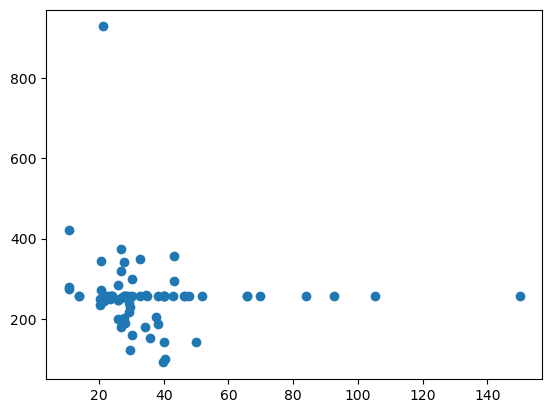

In [80]:
plt.plot(branches_df["length"], branches_df["susceptance"], 'o')

In [79]:
branches_df = pd.read_csv(branch_path)
buses_df = pd.read_csv(bus_path)
buses_df['Lon'] = -buses_df['Lon']
# buses_df

In [75]:
# 2) Merge in coordinates for both ends
df = branches_df.merge(
    buses_df.rename(columns={'node_num':'from_node','Lat':'lat_f','Lon':'lon_f'}),
    on='from_node', how='left'
).merge(
    buses_df.rename(columns={'node_num':'to_node','Lat':'lat_t','Lon':'lon_t'}),
    on='to_node', how='left'
)

In [65]:
buses_df

,node_num,State,Lat,Lon,Offshore_wind_allowed,ISONE_zone
0,0.0,MA,42.642711,-70.865107,1.0,MA
1,1.0,MA,42.479477,-71.396507,1.0,MA
2,2.0,MA,42.331960,-71.020173,1.0,MA
3,3.0,MA,42.169703,-71.179875,1.0,MA
4,4.0,MA,41.644282,-70.576707,1.0,MA
5,5.0,MA,42.311693,-71.940282,0.0,MA
6,6.0,MA,42.358691,-72.776236,0.0,MA
7,7.0,ME,44.958418,-69.250412,0.0,ME
8,8.0,ME,43.829991,-70.263051,0.0,ME
9,9.0,VT,44.161374,-72.685273,0.0,VT


In [73]:
# Correct filtering for existing branches
branches_df = branches_df[branches_df["is_existing"] == 1.0]

In [74]:
branches_df

,line_num,from_node,to_node,is_existing,maxFlow,susceptance,length,from_lat,from_lon
0,0.0,0.0,10.0,1.0,1928.10,260.606415,0.0,42.642711,-70.865107
1,1.0,1.0,2.0,1.0,1119.73,288.642792,0.0,42.479477,-71.396507
2,2.0,1.0,5.0,1.0,511.81,78.939059,0.0,42.479477,-71.396507
3,3.0,1.0,10.0,1.0,4485.68,642.966106,0.0,42.479477,-71.396507
4,4.0,2.0,0.0,1.0,598.82,170.502984,0.0,42.331960,-71.020173
...,...,...,...,...,...,...,...,...,...
66,66.0,16.0,5.0,1.0,508.46,87.191560,0.0,41.649057,-72.239840
67,67.0,16.0,6.0,1.0,1068.21,160.623537,0.0,41.649057,-72.239840
68,68.0,16.0,15.0,1.0,506.74,93.127212,0.0,41.649057,-72.239840
69,69.0,16.0,5.0,1.0,585.15,83.885580,0.0,41.649057,-72.239840


In [49]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1) Filter out zero‑length lines
df = branches_df[branches_df['length'] > 0].copy()

# 2) Prepare X and y
X = df[['length']].values   # shape (n_samples, 1)
y = df['susceptance'].values

# 3) Fit the model
model = LinearRegression()
model.fit(X, y)

# 4) Gather results
slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(X, y)     # equivalent to r2_score(y, model.predict(X))

print(f"Slope:     {slope:.4f}  [susceptance per unit length]")
print(f"Intercept: {intercept:.4f}")
print(f"R² score:  {r2:.4f}")


Slope:     0.0000  [susceptance per unit length]
Intercept: 272.8322
R² score:  1.0000


In [76]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 2) Merge in coordinates for both ends
# df = branches_df.merge(
#     buses_df.rename(columns={'bus_id':'from_bus_id','Lat':'lat_f','Lon':'lon_f'}),
#     on='from_bus_id', how='left'
# ).merge(
#     buses_df.rename(columns={'bus_id':'to_bus_id','Lat':'lat_t','Lon':'lon_t'}),
#     on='to_bus_id', how='left'
# )

# 3) Haversine formula (in kilometers)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    φ1, φ2 = np.radians(lat1), np.radians(lat2)
    Δφ = φ2 - φ1
    Δλ = np.radians(lon2 - lon1)
    a = np.sin(Δφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(Δλ/2)**2
    return 2*R * np.arcsin(np.sqrt(a))

# 4) Compute each branch’s length
df['length_km'] = haversine(
    df['lat_f'], df['lon_f'],
    df['lat_t'], df['lon_t']
)

# 5) Fit linear regression: b = m * length_km + c
X = df[['length_km']].values  # shape (n_branches,1)
y = df['susceptance'].values            # susceptance

model = LinearRegression()
model.fit(X, y)

# Predictions & performance
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"Slope (m):     {model.coef_[0]:.4f}  [b per km]")
print(f"Intercept (c): {model.intercept_:.4f}")
print(f"R² score:      {r2:.4f}")

# 6) (Optional) attach predictions for inspection
df['b_pred'] = y_pred
# print(df[['branch_id','length_km','b','b_pred']])


Slope (m):     -1.6635  [b per km]
Intercept (c): 419.7624
R² score:      0.0793


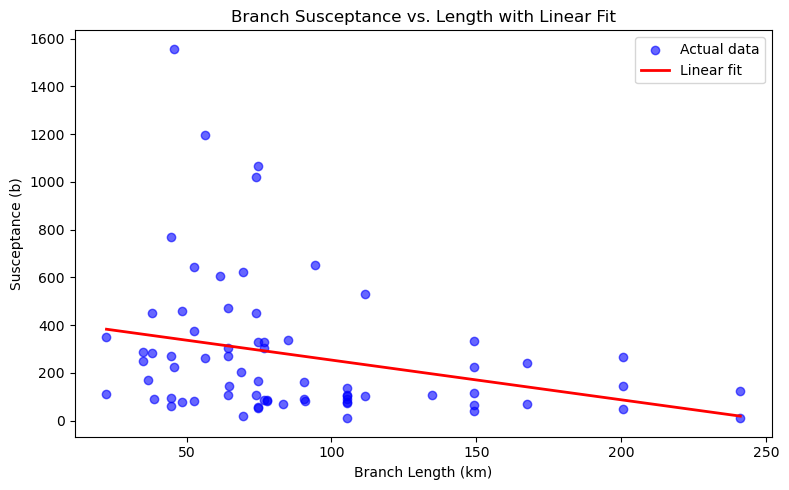

In [77]:
import matplotlib.pyplot as plt

# Scatter plot of actual data
plt.figure(figsize=(8, 5))
# plt.scatter(df['length_km'], df['b'], color='blue', alpha=0.6, label='Actual data')
plt.scatter(df['length_km'], df['susceptance'], color='blue', alpha=0.6, label='Actual data')

# Plot regression line
x_line = np.linspace(df['length_km'].min(), df['length_km'].max(), 100)
# x_line = np.linspace(df['length'].min(), df['length'].max(), 100)
y_line = model.predict(x_line.reshape(-1, 1))
plt.plot(x_line, y_line, color='red', linewidth=2, label='Linear fit')

plt.xlabel('Branch Length (km)')
plt.ylabel('Susceptance (b)')
plt.title('Branch Susceptance vs. Length with Linear Fit')
plt.legend()
plt.tight_layout()
plt.show()